<center><img src="https://github.com/DACSS-CSSmeths/guidelines/blob/main/pics/small_logo_ccs_meths.jpg?raw=true" width="700"></center>









<a target="_blank" href="https://colab.research.google.com/github/DACSS-CSSmeths/Spatial-Analytics/blob/main/index.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Insight from spatial data

Let me bring a file previously prepared in [Colab](https://colab.research.google.com/drive/1poKKGEsOkTTjwi5ildq2-kMet29HYfpQ?usp=sharing) using FuzzyMerge:

In [1]:
# map
import geopandas as gpd

peru_hdi_map_link="https://github.com/DACSS-CSSmeths/Spatial-Analytics/raw/refs/heads/main/map/perudata.gpkg"

peru_hdi_map=gpd.read_file(peru_hdi_map_link,layer='hdi')

peru_hdi_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   DEPARTAMEN       1874 non-null   object  
 1   PROVINCIA        1874 non-null   object  
 2   municipality     1874 non-null   object  
 3   Ubigeo           1874 non-null   object  
 4   Poblacion        1874 non-null   int64   
 5   Superficie       1874 non-null   float64 
 6   hdi              1874 non-null   float64 
 7   graduated_HS     1874 non-null   float64 
 8   No_basicNeeds    1874 non-null   float64 
 9   No_sanitaryServ  1874 non-null   float64 
 10  No_graduated_HS  1874 non-null   float64 
 11  geometry         1874 non-null   geometry
dtypes: float64(6), geometry(1), int64(1), object(4)
memory usage: 175.8+ KB


This is a GeoDF with data on Human Development at the municipal (_municipality_ column) level, including this relevant social info:


* **hdi**: The human development index of the municipality

* **graduated_HS**: Percent of population that finished High School

* **No_graduated_HS**: Percent of population that did not finished High School

* **No_basicNeeds**: Percent of households without basic needs.

* **No_sanitaryServ**:Percent of households without sanitary services.

Take a quick look:

In [2]:
peru_hdi_map.head()

,DEPARTAMEN,PROVINCIA,municipality,Ubigeo,Poblacion,Superficie,hdi,graduated_HS,No_basicNeeds,No_sanitaryServ,No_graduated_HS,geometry
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,230110,123662,187.74,0.578968,71.178389,15.8,0.8,28.821611,"MULTIPOLYGON (((-70.17413 -18.12896, -70.17461..."
1,TACNA,TACNA,POCOLLAY,230108,22319,265.65,0.645954,75.825743,16.1,0.9,24.174257,"MULTIPOLYGON (((-69.93475 -17.92557, -69.90467..."
2,TACNA,TACNA,CALANA,230103,3338,108.38,0.564102,77.829717,15.9,3.3,22.170283,"MULTIPOLYGON (((-70.11604 -17.91106, -70.11457..."
3,TACNA,TACNA,TACNA,230101,80845,1877.78,0.696613,75.491958,7.4,0.6,24.508042,"MULTIPOLYGON (((-70.3149 -17.94498, -70.30682 ..."
4,TACNA,TACNA,SAMA,230109,2679,1115.98,0.552622,70.500250,52.4,10.8,29.499750,"MULTIPOLYGON (((-70.42497 -17.88934, -70.48022..."


## Mining one variable beyond choropleths

Let me use the *Fisher_Jenks* scheme on one variable, the 'hdi':

<Axes: >

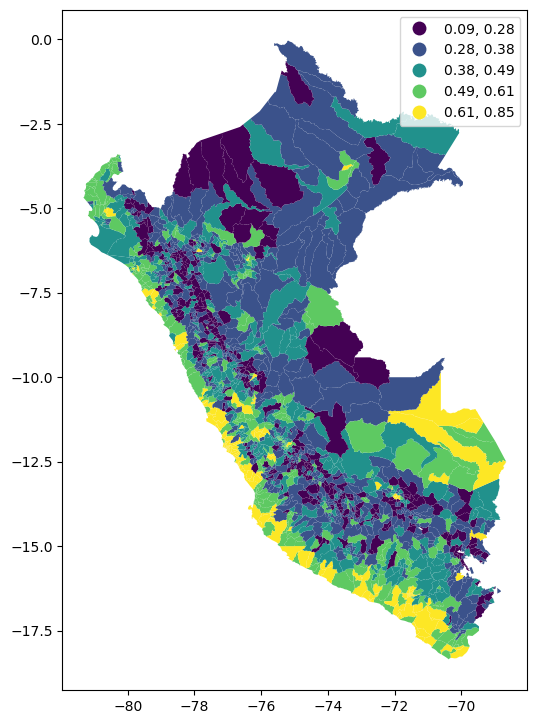

In [3]:
peru_hdi_map.plot(
    column="hdi", 
    scheme="fisherjenks",
    legend=True, figsize=(6,10)
)

From the last [tutorial](https://dacss-cssmeths.github.io/Spatial-Exploring/), even though there are ways to highlight some relevant values, now we will work to get statistically significant patterns (neihborhoods).

We are using maps to relate values to location: **Are the values of my unit of analysis affected by their location?**

Let's follow these steps to propose an answer:

1. Identify the **neighborhood**: One location should be able to **see** how their neighbors "behave".
2. Compute a measure of neighborhood effect: how know statiscally whether proximity is affecting or not.
3. If proximity is affecting, find the neighborhoods that statistically show some spatial pattern.


## 1. Identify the _neighborhood_

The neighborhood is the set of objects around one object. The problem is the meaning of "around". The figure below shows the two ways we can identify a neighborhood (from [Vilella at al.](https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-020-00228-9)):



<center><img src="https://github.com/DACSS-CSSmeths/Spatial-Analytics/blob/main/neighborhood.jpg?raw=true" width="700"></center>



* In maps, the **QUEEN** approach considers that two spatial objects (i.e. polygons) are neighbors if their borders share one coordinate (point);

* the **ROOK** approach considers that two spatial objects  are neighbors if their borders share two coordinates (a line). 

* Of course, you can have neighbors that are not contiguous (touching your borders), particularly if they are not polygons (lines or points). In that case you have a different approach: the nearest neighbor or **KNN** (you count as many "k" neighbors you want).

Let me call the functions I need:

In [4]:
from libpysal.weights import Queen, Rook, KNN

Now, I will find all the neighbors:

In [5]:
w_rook = Rook.from_dataframe(peru_hdi_map,use_index=False) 
w_queen = Queen.from_dataframe(peru_hdi_map,use_index=False)
w_knn8 = KNN.from_dataframe(peru_hdi_map, k=8) # you want '8' closest neighbors

/Users/JoseManuel/opt/anaconda3/envs/CSSmeth_3_10/lib/python3.10/site-packages/libpysal/weights/contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 89, 122.
  W.__init__(self, neighbors, ids=ids, **kw)
/Users/JoseManuel/opt/anaconda3/envs/CSSmeth_3_10/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 89, 122.
  W.__init__(self, neighbors, ids=ids, **kw)


The QUEEN and ROOK sent a warning, because some polygons had no neighbors (islands).
Here they are:

In [6]:
#the rows:
w_queen.islands, w_rook.islands, 

([89, 122], [89, 122])

In [7]:
#the municipalities
peru_hdi_map.loc[w_queen.islands,'municipality']

89       ANAPIA
122    AMANTANI
Name: municipality, dtype: object

In [8]:
# just plotting
peru_hdi_map.iloc[w_queen.islands,:].explore()

Notice the inventory of neighbors:

In [9]:
import pandas as pd # using pandas to ease analysis of data

# I am turning "w_queen.neighbors" into a pandas column (a 'Series')

pd.Series(w_queen.neighbors).head()

0                           [1, 3]
1              [0, 16, 2, 3, 5, 9]
2                        [1, 5, 9]
3    [0, 1, 4, 5, 8, 13, 1806, 16]
4                [3, 6, 8, 13, 14]
dtype: object

Above, you see the indexes (row numbers); that is, the polygon 0 (the first row) has polygon "1" and "3" as neighbors. 
You can also know how many neighbors each on has:

In [10]:
pd.Series(w_queen.cardinalities).head()

0    2
1    6
2    3
3    8
4    5
dtype: int64

In this case, we can see the counting of the above: polygon 0 (the first row) has two neighbors. 

You may not expect the same results from both techniques. The next figure shows you that.

Text(0.5, 0, 'Amount of Neighbors of a Municipality')

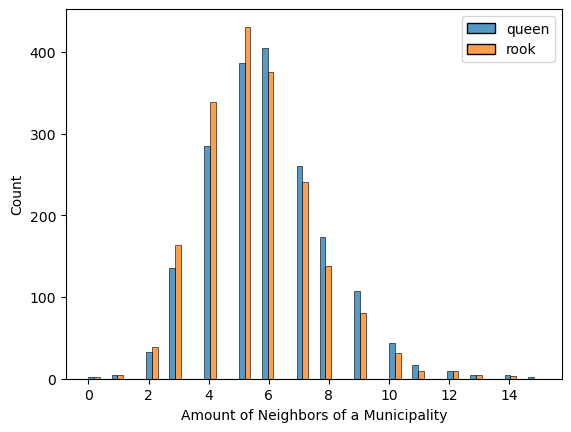

In [11]:
Queen_Rook={'queen':w_queen.cardinalities,'rook':w_rook.cardinalities}

import seaborn as sea
import pandas as pd
from matplotlib import pyplot as plt


sea.histplot(pd.DataFrame(Queen_Rook),multiple="dodge")
plt.xlabel('Amount of Neighbors of a Municipality')

## 2. Compute a measure of neighborhood effect: Global spatial correlation

### The adjacency matrix
We were able compute all the previous information because the algorithms _Queen_, _Rook_ and _KNN_ created an **adjacency matrix**. Take a look:

In [12]:
pd.DataFrame(*w_queen.full()) # 1 means both are neighbors

,0,1,2,3,4,5,6,7,8,9,...,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The presence of **1** means two units are neighbors, for example 1871 and 1870 are neighbors, but none of them is connected to 1869:

<Axes: >

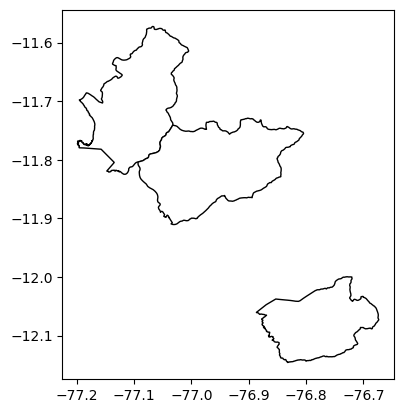

In [13]:
peru_hdi_map.loc[[1869,1870,1871],:].plot(color='w', edgecolor='k')

### The spatial weight matrix

The spatial correlation needs the previous adjacency matrix as a **weight matrix**, you get it this way:

In [14]:
w_knn8.transform = 'R'

 Now, the sum of every row is ONE:

In [15]:
# after transformation
pd.DataFrame(*w_knn8.full())

,0,1,2,3,4,5,6,7,8,9,...,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873
0,0.000,0.125,0.125,0.125,0.125,0.125,0.000,0.0,0.125,0.125,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.0
1,0.125,0.000,0.125,0.125,0.000,0.125,0.000,0.0,0.125,0.125,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.0
2,0.125,0.125,0.000,0.125,0.000,0.125,0.000,0.0,0.125,0.125,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.0
3,0.125,0.125,0.125,0.000,0.000,0.125,0.000,0.0,0.125,0.125,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.0
4,0.125,0.000,0.125,0.000,0.000,0.125,0.125,0.0,0.125,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.0,0.0,0.0,0.125,0.0,0.0,0.000,0.000,0.000,0.0
1870,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.125,0.125,0.0
1871,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.125,0.000,0.125,0.0
1872,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.125,0.000,0.000,0.0


You see the sum by rows (axis=1) here:

In [16]:
pd.DataFrame(*w_knn8.full()).sum(axis=1)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1869    1.0
1870    1.0
1871    1.0
1872    1.0
1873    1.0
Length: 1874, dtype: float64

### The Global Moran

Most people are familiar with Pearson correlation coefficient (_Person's R_). The R coefficient tells the relationship between two variables. We will do something similar now.

Take the variable _hdi_ from the GeoDF *peru_hdi_map*. But in this case, we will not use another variable. We will the same variable twice! that is: comparing if there is some correlation between the _hdi_ of a municipality, with the _hdi_ of the neighbors. The results is known as the **Moran's I** statistic. Let's get it:

In [17]:
from esda.moran import Moran

# we use the variable 'hdi' and the weight matrix
moranHDI = Moran(y=peru_hdi_map['hdi'], 
                 w=w_knn8)

# results
moranHDI.I, moranHDI.p_sim

(np.float64(0.6344647804225823), np.float64(0.001))

Now we know that there is significant (0.001)  positive correlation (0.63): **when the value of hdi is high in one location, it is usually high in the neighbors (or if it is low, it is usually low in the neighbors)**. 

So far we have the GLOBAL Moran's I. That tells us the global tendency. But it would be even more interesting to know where the areas where spatial correlation (neighboorhood effect!) is actually happening. For that you need the local Moran!

## 3. Find Spatial patterns on neigborhoods

Here we need to compute the  **Local Index of Spatial Association** (LISA -local Moran) for each map object. That will help us identify different **quadrants**, that represent a spatial clusters (spots) or spatial outliers:

* A **hotSpot (HH)** are geometries who are in a neighborhood of high values of a particular variable.

* A **coldSpot (LL)** are geometries who are in a neighborhood of low values  of a particular variable.

* A **coldOutlier (LH)** is a geometry whose value in the variable is low BUT is surrounded with polygons with  high values  of a particular variable.

* A **hotOutlier (HL)** is a geometry whose value in the variable is high BUT is surrounded with polygons with  low values  of a particular variable.

It is also possible that no significant correlation is detected. Let's see compute LISA:

In [18]:
# A LISA for each district using hdi
from esda.moran import Moran_Local

lisa_HDI = Moran_Local(y=peru_hdi_map['hdi'], 
                       w=w_knn8,
                       seed=2022) # use this seed if you want to get the same results.

You have this information in lisa_HDI:

In [19]:
# quadrant, # significance
ResultLISA=pd.DataFrame({'lisa_Qlabel':lisa_HDI.q, 'lisa_Qsig':lisa_HDI.p_sim})
ResultLISA

,lisa_Qlabel,lisa_Qsig
0,1,0.001
1,1,0.008
2,1,0.005
3,1,0.003
4,1,0.001
...,...,...
1869,1,0.001
1870,1,0.001
1871,1,0.001
1872,1,0.001


The first column **lisa_Qlabel** tells you to what quadrant the municipality is in; this is the legend: 

* 1 HH
* 2 LH
* 3 LL
* 4 HL

The LISA also offers you the probability that the local relationship is statistically significant. The second column **lisa_Qsig** tells you that. We need to identify which are not statistically significant, so let me relabel as **0** the non significant quadrant. Let's follow these steps:

1. Identify which QUADRANT LABELs are NOT significant:

In [20]:
# renaming q as 0, if p is less than 0.05
peru_hdi_map['HDI_quadrant']=[q if p <0.05 else 0 for q,p in zip(ResultLISA.lisa_Qlabel,ResultLISA.lisa_Qsig)  ]

Now, we know:

In [21]:
# quadrant: 0:No_sig 1 HH,  2 LH,  3 LL,  4 HL
peru_hdi_map['HDI_quadrant'].value_counts()

HDI_quadrant
0    1005
3     422
1     371
4      56
2      20
Name: count, dtype: int64

We have 1005 districts (polygons) where the local correlation is not statistically significant. We have 422 districts in neighborhoods of the kind LL (all have low values in HDI), and so on.


2. Rename **HDI_quadrant**

   Instead of numbers, we can have labels:

In [22]:
# the dictionary to make changes
newLabels = {0: '0_NoSig',1: '1_HotSpot',2: '2_ColdOutlier',3: '3_ColdSpot',4: '4_HotOutlier'}
newLabels

{0: '0_NoSig',
 1: '1_HotSpot',
 2: '2_ColdOutlier',
 3: '3_ColdSpot',
 4: '4_HotOutlier'}

Here we recode:

In [23]:
peru_hdi_map.replace({'HDI_quadrant':newLabels},inplace=True)


# now
peru_hdi_map['HDI_quadrant'].value_counts()

HDI_quadrant
0_NoSig          1005
3_ColdSpot        422
1_HotSpot         371
4_HotOutlier       56
2_ColdOutlier      20
Name: count, dtype: int64

We have the data ready.

In [24]:
peru_hdi_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   DEPARTAMEN       1874 non-null   object  
 1   PROVINCIA        1874 non-null   object  
 2   municipality     1874 non-null   object  
 3   Ubigeo           1874 non-null   object  
 4   Poblacion        1874 non-null   int64   
 5   Superficie       1874 non-null   float64 
 6   hdi              1874 non-null   float64 
 7   graduated_HS     1874 non-null   float64 
 8   No_basicNeeds    1874 non-null   float64 
 9   No_sanitaryServ  1874 non-null   float64 
 10  No_graduated_HS  1874 non-null   float64 
 11  geometry         1874 non-null   geometry
 12  HDI_quadrant     1874 non-null   object  
dtypes: float64(6), geometry(1), int64(1), object(5)
memory usage: 190.5+ KB


Let's save this data:

In [25]:
peru_hdi_map.to_file("peru_hdi_map.gpkg", layer='spatial', driver="GPKG")

We can use this plot this last column:

<Axes: >

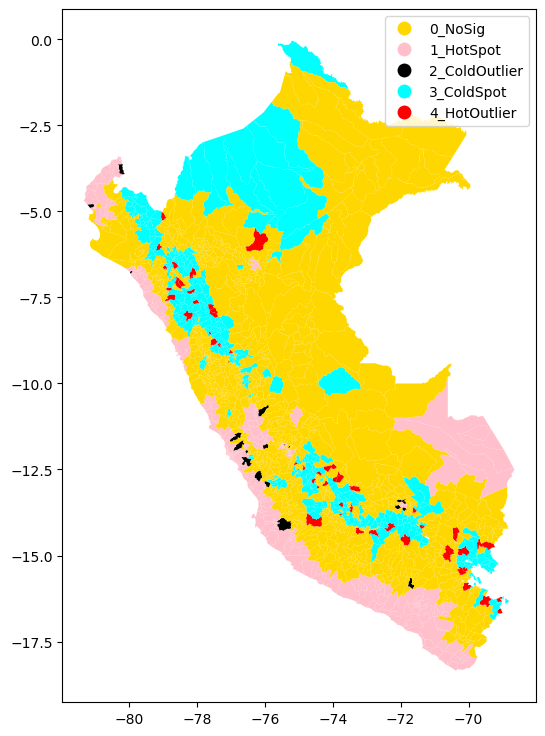

In [26]:
from matplotlib import colors

# custom colors
myColMap = colors.ListedColormap([ 'gold', 'pink', 'k', 'cyan','red'])

peru_hdi_map.plot(
    column="HDI_quadrant",  
    cmap=myColMap,  # colormap
    legend=True, figsize=(7,9)
)

One of the most important insights you get, is discovering the outliers (HL or LH). For instance these ones:

<Axes: >

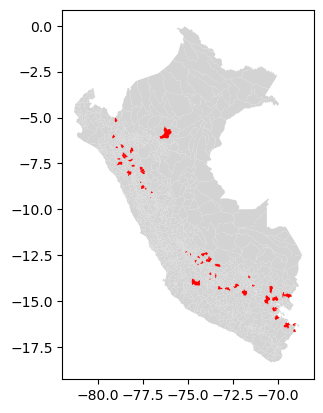

In [27]:
base=peru_hdi_map.plot(color='lightgrey')
peru_hdi_map[peru_hdi_map.HDI_quadrant=='4_HotOutlier'].plot(color='red', ax=base)

From here, you can propose other queries:

In [28]:
# the mean and median per quadrant:
peru_hdi_map.groupby('HDI_quadrant').agg({'hdi': ['mean','median']})

hdi          
                   mean    median
HDI_quadrant                     
0_NoSig        0.388691  0.381645
1_HotSpot      0.603848  0.598940
2_ColdOutlier  0.349765  0.374688
3_ColdSpot     0.282770  0.286910
4_HotOutlier   0.468553  0.449375

In [29]:
# which are the min value per quadrant:
whichInfo=['municipality','HDI_quadrant','hdi']
theVar='hdi'
theGroups='HDI_quadrant'
peru_hdi_map.loc[peru_hdi_map.groupby(theGroups)[theVar].transform("min") == peru_hdi_map[theVar]][whichInfo]

,municipality,HDI_quadrant,hdi
492,CCORCA,2_ColdOutlier,0.234918
847,SAN PEDRO DE CASTA,1_HotSpot,0.414441
1369,CHETILLA,0_NoSig,0.116449
1400,JOSE GALVEZ,4_HotOutlier,0.409923
1722,LAGUNAS,3_ColdSpot,0.091195


These are the positions:

In [30]:
theMins=peru_hdi_map.loc[peru_hdi_map.groupby(theGroups)[theVar].transform("min") == peru_hdi_map[theVar]][whichInfo]
theMins.index

Index([492, 847, 1369, 1400, 1722], dtype='int64')

Use those positions to plot:

In [31]:
peru_hdi_map.iloc[theMins.index,:].explore(column="HDI_quadrant",
                                           tiles='CartoDB.Positron',
                                           cmap=myColMap, legend=True, style_kwds={'width':4,'color':'black'}
)

To check which is what in the plot above, we should use zoom. 

# Neighborhoods based on two variables

Remember we have these variables:

In [32]:
peru_hdi_map.columns

Index(['DEPARTAMEN', 'PROVINCIA', 'municipality', 'Ubigeo', 'Poblacion',
       'Superficie', 'hdi', 'graduated_HS', 'No_basicNeeds', 'No_sanitaryServ',
       'No_graduated_HS', 'geometry', 'HDI_quadrant'],
      dtype='object')

Let me see a classical correlation between two variables:

In [33]:
peru_hdi_map[['No_sanitaryServ','No_graduated_HS']].corr()

,No_sanitaryServ,No_graduated_HS
No_sanitaryServ,1.000000,0.200932
No_graduated_HS,0.200932,1.000000


<Axes: xlabel='No_sanitaryServ', ylabel='No_graduated_HS'>

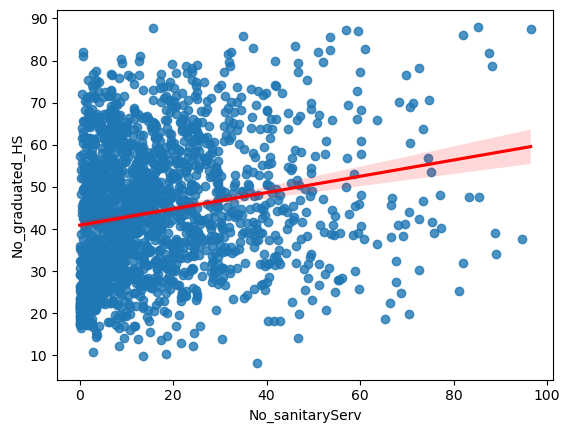

In [34]:
sea.regplot(data=peru_hdi_map, x='No_sanitaryServ',y='No_graduated_HS',line_kws=dict(color="r"))

The Peason's R is suggestion a mild positive correlation. The higher the lack of sanitary services in a municipality, the higher the share of people not graduating in that municipality. So, Pearson's R tells the trend of the two variables in the same unit of analysis.

Let me see if those variables are also influenced by proximity:


In [35]:
from esda.moran import Moran_BV
noToilet_HS=Moran_BV(x=peru_hdi_map['No_sanitaryServ'],y=peru_hdi_map['No_graduated_HS'], w=w_knn8)
noToilet_HS.I,noToilet_HS.p_sim

(np.float64(0.10285641236938908), np.float64(0.001))

The global **Bivariate** Moran is telling that there are neighborhoods where a geometry with a high value in *No_sanitaryServ* is surrounded by high values in *No_graduated_HS* (the low-low also holds as you know).

Let's find those neighborhoods as before:

In [36]:
from esda.moran import Moran_Local_BV

#HH=1, LH=2, LL=3, HL=4

# this is for the local neighborhood:
moran_loc_bv = Moran_Local_BV(x=peru_hdi_map['No_sanitaryServ'],y=peru_hdi_map['No_graduated_HS'], w=w_knn8,seed=2022)

# results as a dataframe
ResultLISA_BV=pd.DataFrame({'BV_lisa_Qlabel':moran_loc_bv.q, 'BV_lisa_Qsig':moran_loc_bv.p_sim})

# identifying the non significant relationships
peru_hdi_map['HDI_quadrant_BV']=[q if p <0.05 else 0 for q,p in zip(ResultLISA_BV.BV_lisa_Qlabel,ResultLISA_BV.BV_lisa_Qsig)  ]

# relabelling them
peru_hdi_map.replace({'HDI_quadrant_BV':newLabels},inplace=True)

# we have
peru_hdi_map['HDI_quadrant_BV'].value_counts()

HDI_quadrant_BV
0_NoSig          922
3_ColdSpot       380
2_ColdOutlier    245
1_HotSpot        168
4_HotOutlier     159
Name: count, dtype: int64

For example, we can state that  we have 380 municipalities with low percent of houses that lack sanitary services, surrounded by municipalities with also low percent of people that did not finished high school. 
Notice that several spatial outliers are present, for instance, you know that there are 159 municipalities with high percent of houses that lack sanitary services, surrounded by municipalities with low percent of people that did not finished high school. 

Here we can see them:

<Axes: >

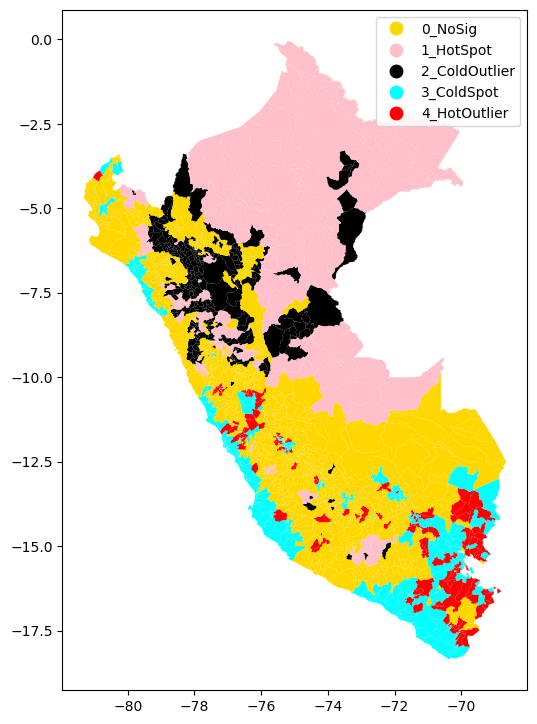

In [37]:
peru_hdi_map.plot(
    column="HDI_quadrant_BV",  
    cmap=myColMap,  # colormap
    legend=True, 
    figsize=(6,9)
)

In [38]:
# currently we have:
peru_hdi_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   DEPARTAMEN       1874 non-null   object  
 1   PROVINCIA        1874 non-null   object  
 2   municipality     1874 non-null   object  
 3   Ubigeo           1874 non-null   object  
 4   Poblacion        1874 non-null   int64   
 5   Superficie       1874 non-null   float64 
 6   hdi              1874 non-null   float64 
 7   graduated_HS     1874 non-null   float64 
 8   No_basicNeeds    1874 non-null   float64 
 9   No_sanitaryServ  1874 non-null   float64 
 10  No_graduated_HS  1874 non-null   float64 
 11  geometry         1874 non-null   geometry
 12  HDI_quadrant     1874 non-null   object  
 13  HDI_quadrant_BV  1874 non-null   object  
dtypes: float64(6), geometry(1), int64(1), object(6)
memory usage: 205.1+ KB


Let me rewrite the map file:

In [39]:
peru_hdi_map.to_file("peru_hdi_map.gpkg", layer='spatial', driver="GPKG")



<div class="alert-success">

<header>
    <h1>Homework 1 (alternative)</h1>
    
  </header>
    

    
</div>

You will apply these concepts to the USA counties.
See CANVAS for more details.